## Shows the OOM repro

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tsai.all import *
from joblib import Parallel, delayed
from openavalancheproject.tsai_utilities import *
import numpy as np
import zarr

In [3]:
my_setup(zarr)

os             : Linux-5.4.0-91-generic-x86_64-with-glibc2.17
python         : 3.8.11
tsai           : 0.2.24
fastai         : 2.5.3
fastcore       : 1.3.26
zarr           : 2.10.0
torch          : 1.9.1+cu102
n_cpus         : 24
device         : cuda (GeForce GTX 1080 Ti)


In [40]:
learn.feature_importance()

Selected metric: accuracy
Computing feature importance...


MemoryError: Unable to allocate 315. GiB for an array with shape (60000, 978, 1441) and data type float32

# Full Repro

In [6]:
data_root = '/media/scottcha/Data2/OAPMLData/'

ml_path = data_root + '/5.MLData/'
num_features = 774
interpolation = 1
label = 'Day1DangerAboveTreeline'
file_label = 'ca_co_day1above_3h_med'


In [7]:
X = zarr.open(ml_path + 'X_' + file_label + '.zarr', mode='r')

In [8]:
X.shape

(60000, 978, 1441)

In [9]:
utils = TSAIUtilities(X, label)

In [10]:
#read in the corresponding label files and concat them
#can get the right values here based on the contents of hte ml_path directory
num_train_files = 20
file_list = []
for i in range(num_train_files):
    file_list.append(pd.read_parquet(ml_path + '/y_train_batch_' + str(i) + '_' + file_label + '.parquet'))

    
num_test_files = 4
for i in range(num_test_files):
    file_list.append(pd.read_parquet(ml_path + '/y_test_batch_' + str(i + num_train_files) + '_' + file_label + '.parquet'))
    
y_df = pd.concat(file_list).reset_index(drop=True)

In [11]:
y_df['Day1DangerAboveTreeline'].value_counts()

Moderate        15000
High            15000
Considerable    15000
Low             15000
Name: Day1DangerAboveTreeline, dtype: int64

In [12]:
y_df.shape[0]

60000

In [11]:
y, cat_dict = utils.get_y_as_cat(y_df)
cat_dict

{0: 'Low', 1: 'Moderate', 2: 'Considerable', 3: 'High'}

In [12]:
#index file which indicates which rows in X are train or test
#be carful these don't overlap
num_test = 10000
train_test_split = y.shape[0]-num_test
sample_frac = .5
#can use a smaller train subset to make development faster
splits_2 = (L(list(pd.Series([i for i in range(0,train_test_split)]).sample(frac=sample_frac).values)).shuffle(), L(list(pd.Series([i for i in range(train_test_split,train_test_split+num_test)]).sample(frac=sample_frac).values)).shuffle())

In [13]:
splits_2

((#25000) [17426,9498,49782,39029,29397,29209,179,14846,6648,46992...],
 (#5000) [51554,59757,53630,53136,56086,59921,54161,50610,56399,59671...])

In [14]:
#create the dataset
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits_2, inplace=False)

<AxesSubplot:title={'center':'1'}>

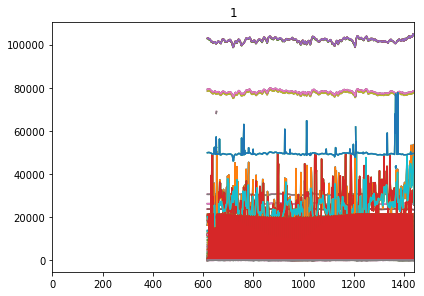

In [15]:
#check on set
show_at(dsets.valid, 1)

In [16]:
#create the dataloader
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64], batch_tfms=[TSStandardize(by_var=True), Nan2Value()], num_workers=12, inplace=False)

In [17]:
#check both the train and test sets to ensure that there aren't full rows with all nulls

CPU times: user 7.64 s, sys: 351 ms, total: 7.99 s
Wall time: 7.95 s


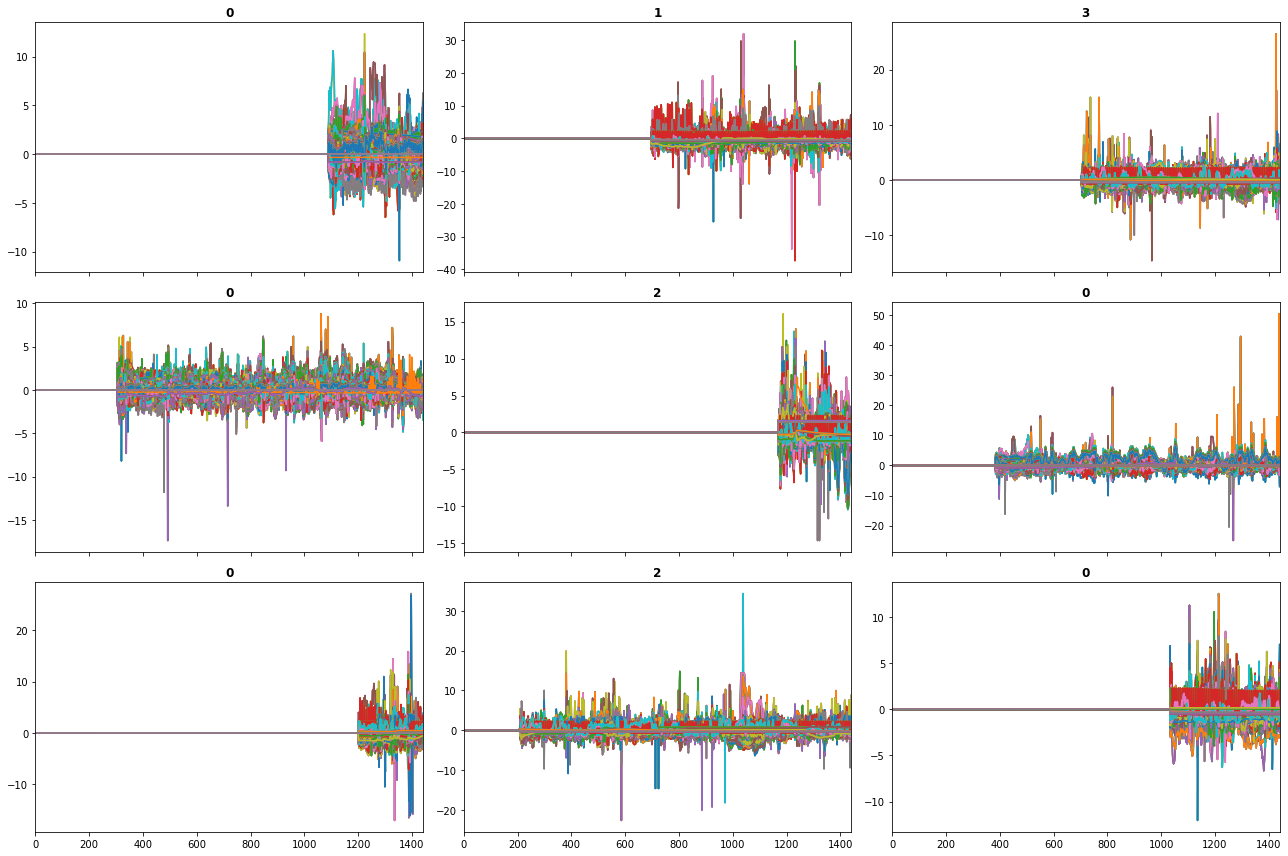

In [18]:
%%time
dls.show_batch()

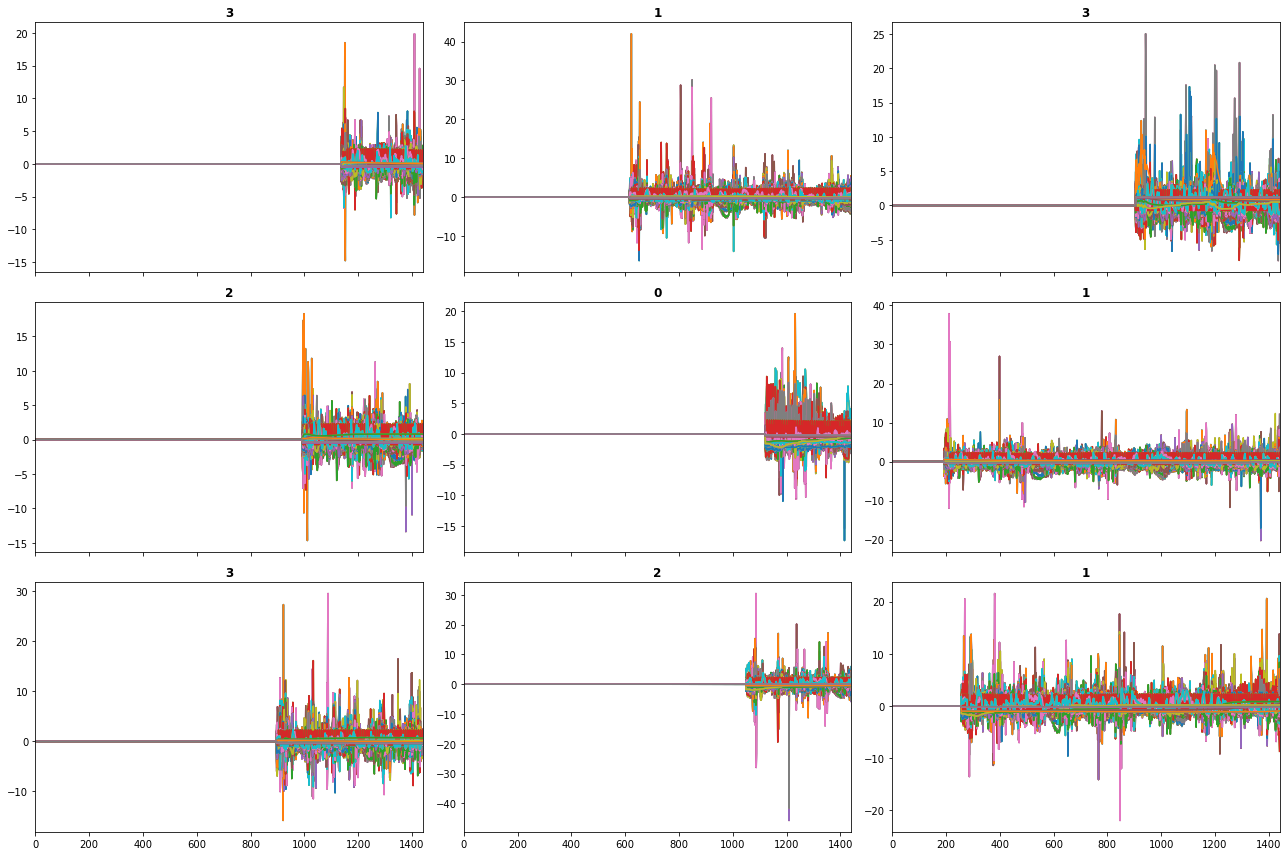

In [19]:
dls.valid.show_batch()

In [20]:
dls.c

4

In [21]:
dls.vars

978

In [22]:
model = InceptionTimePlus(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)

In [23]:
learn.fit_one_cycle(1, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.130399,1.289522,0.365600,01:47


## Shows the OOM repro

In [40]:
learn.feature_importance()

Selected metric: accuracy
Computing feature importance...


MemoryError: Unable to allocate 315. GiB for an array with shape (60000, 978, 1441) and data type float32